<a href="https://colab.research.google.com/github/YasinsSE/AidFlow/blob/main/SVHN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import All Necessary Libraries

In [194]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
from scipy.io import loadmat
from urllib import request
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Load and Preprocess Dataset

In [158]:
# Ensure the 'data' directory exists
if not os.path.exists('data'):
    os.makedirs('data')

# Downloading the SVHN dataset from http://ufldl.stanford.edu/housenumbers/ into the 'data' folder
if not os.path.exists('data/train_32x32.mat'):
    print("Downloading SVHN training dataset")
    !wget -P data/ http://ufldl.stanford.edu/housenumbers/train_32x32.mat
else:
    print("SVHN training dataset 'train_32x32.mat' already exists in 'data' folder")

if not os.path.exists('data/test_32x32.mat'):
    print("Downloading SVHN testing dataset")
    !wget -P data/ http://ufldl.stanford.edu/housenumbers/test_32x32.mat
else:
    print("SVHN testing dataset 'test_32x32.mat' already exists in 'data' folder")

SVHN training dataset 'train_32x32.mat' already exists in 'data' folder
SVHN testing dataset 'test_32x32.mat' already exists in 'data' folder


In [159]:
# Load the dataset
train_data = loadmat('data/train_32x32.mat')
test_data = loadmat('data/test_32x32.mat')

# Extract images and labels
x_train = train_data['X']
y_train = train_data['y']
x_test = test_data['X']
y_test = test_data['y']

In [160]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)


In [161]:
# Reshape images to match TensorFlow format
x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

In [162]:
# Normalize images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [163]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(73257, 32, 32, 3) (73257, 1)
(26032, 32, 32, 3) (26032, 1)


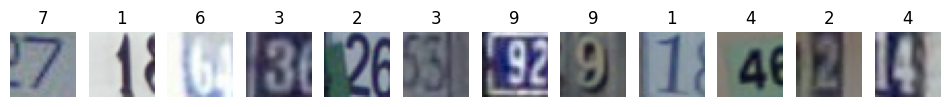

In [164]:
figure, ax = plt.subplots(1,12, figsize=(12,1))
for i in range(12):
    index = np.random.randint(x_train.shape[0])
    ax[i].set_axis_off()
    ax[i].imshow(x_train[index])
    ax[i].set_title(y_train[index,0])

In [165]:
# Converting to grayscale images
x_train = np.mean(x_train, axis=-1, keepdims = True)
x_test = np.mean(x_test, axis=-1,  keepdims = True)
print(x_train.shape)
print(x_test.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


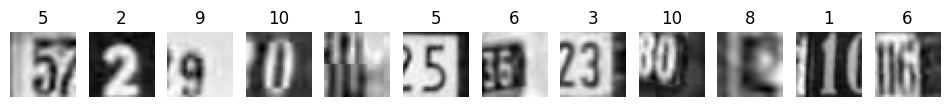

In [166]:
figure, ax = plt.subplots(1,12, figsize=(12,1))
for i in range(12):
    index = np.random.randint(x_train.shape[0])
    ax[i].set_axis_off()
    ax[i].imshow(x_train[index],cmap="gray")
    ax[i].set_title(y_train[index,0])

In [167]:
# Converting label 10 to label 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

# Define Model Architecture

In [192]:
def create_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        # First convolutional block
        Conv2D(32, kernel_size=(3, 3), padding="SAME", activation="relu"),
        MaxPool2D((2, 2)),
        BatchNormalization(),

        # Second convolutional block
        Conv2D(64, kernel_size=(3, 3), padding="SAME", activation="relu"),
        MaxPool2D((2, 2)),
        BatchNormalization(),

        # Third convolutional block
        Conv2D(128, kernel_size=(3, 3), padding="SAME", activation="relu"),
        MaxPool2D((2, 2)),
        BatchNormalization(),

        # Flattening the outputs for fully connected layers
        Flatten(),

        # Fully connected layer
        Dense(64, activation="relu"),
        Dropout(0.5),  # Dropout to prevent overfitting

        # Output layer
        Dense(10, activation="softmax")
    ])
    return model

In [169]:
def create_callbacks():
    # Checkpoint path
    cnn_model_checkpoint_path = "./model_checkpoints_best/cnn_checkpoint.weights.h5"

    os.makedirs(os.path.dirname(cnn_model_checkpoint_path), exist_ok=True)

    # ModelCheckpoint callback
    callback_checkpoint = ModelCheckpoint(filepath=cnn_model_checkpoint_path,
                                          save_weights_only=True,
                                          monitor="val_accuracy",
                                          save_best_only=True,
                                          verbose=1)

    # EarlyStopping callback
    callback_early_stopping = EarlyStopping(monitor="val_accuracy",
                                            patience=5,
                                            verbose=1)

    return [callback_checkpoint, callback_early_stopping]

In [170]:
def compile_cnn_model(model):
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    return model

In [171]:
def train_cnn_model(model, x_train, y_train, x_test, y_test, epochs=30, batch_size=64):
    callbacks = create_callbacks()

    history = model.fit(x_train, y_train,
                        verbose=2,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)
    return history

In [172]:
def evaluate_cnn_model(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'Test accuracy: {test_acc:.4f}')
    return test_loss, test_acc

In [173]:
def predict_with_cnn_model(model, x_test):
    predictions = model.predict(x_test)

    # Example: Predicting the first image in the test set
    first_prediction = np.argmax(predictions[0])

    # Visualize the first test image
    plt.imshow(x_test[0].reshape(32, 32), cmap='gray')
    plt.title(f'Predicted Label: {first_prediction}')
    plt.show()

    return predictions

# Train and Evaluate the Model

In [195]:
model_cnn = create_cnn_model((32,32,1))
model_cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,354 (880.29 KB)

 Trainable params: 224,906 (878.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [175]:
model_cnn = compile_cnn_model(model_cnn)

In [176]:
history = train_cnn_model(model_cnn, x_train, y_train, x_test, y_test, epochs=30, batch_size=128)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.80482, saving model to ./model_checkpoints_best/cnn_checkpoint.weights.h5
573/573 - 12s - 21ms/step - accuracy: 0.6186 - loss: 1.1304 - val_accuracy: 0.8048 - val_loss: 0.6648
Epoch 2/30

Epoch 2: val_accuracy improved from 0.80482 to 0.84611, saving model to ./model_checkpoints_best/cnn_checkpoint.weights.h5
573/573 - 3s - 6ms/step - accuracy: 0.8317 - loss: 0.5591 - val_accuracy: 0.8461 - val_loss: 0.5101
Epoch 3/30

Epoch 3: val_accuracy improved from 0.84611 to 0.89110, saving model to ./model_checkpoints_best/cnn_checkpoint.weights.h5
573/573 - 5s - 9ms/step - accuracy: 0.8646 - loss: 0.4582 - val_accuracy: 0.8911 - val_loss: 0.3767
Epoch 4/30

Epoch 4: val_accuracy improved from 0.89110 to 0.89405, saving model to ./model_checkpoints_best/cnn_checkpoint.weights.h5
573/573 - 5s - 9ms/step - accuracy: 0.8818 - loss: 0.3984 - val_accuracy: 0.8941 - val_loss: 0.3773
Epoch 5/30

Epoch 5: val_accuracy improved from 0.89405 to 0.

In [177]:
test_loss, test_acc = evaluate_cnn_model(model_cnn, x_test, y_test)

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9095 - loss: 0.4192
Test accuracy: 0.9117


814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


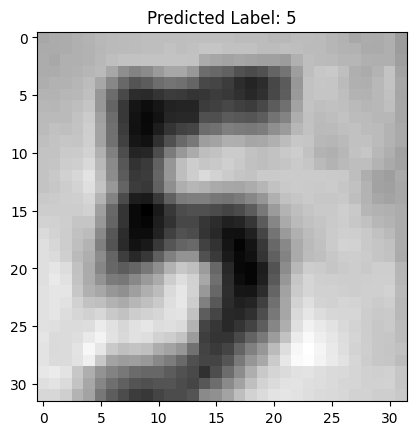

In [178]:
predictions = predict_with_cnn_model(model_cnn, x_test)

In [179]:
def calculate_classification_report(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Precision, Recall and F1-Score report
    report = classification_report(y_test, y_pred_classes, digits=4)
    print("Classification Report:")
    print(report)
    return report

In [180]:
def calculate_roc_auc(model, x_test, y_test):
    y_pred = model.predict(x_test)

    y_test_categorical = to_categorical(y_test)  # Convert labels to one-hot encoding
    auc = roc_auc_score(y_test_categorical, y_pred, multi_class='ovr')

    print(f"ROC AUC Score: {auc:.4f}")
    return auc

In [181]:
classification_report = calculate_classification_report(model_cnn, x_test, y_test)
roc_auc = calculate_roc_auc(model_cnn, x_test, y_test)

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8955    0.9042    0.8999      1744
           1     0.9359    0.9361    0.9360      5099
           2     0.9407    0.9376    0.9392      4149
           3     0.8791    0.8803    0.8797      2882
           4     0.9316    0.9184    0.9250      2523
           5     0.9094    0.9216    0.9154      2384
           6     0.8916    0.8948    0.8932      1977
           7     0.9350    0.8910    0.9125      2019
           8     0.9007    0.8578    0.8787      1660
           9     0.8248    0.9091    0.8649      1595

    accuracy                         0.9117     26032
   macro avg     0.9044    0.9051    0.9044     26032
weighted avg     0.9123    0.9117    0.9118     26032

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
ROC AUC Score: 0.9924


# Visualize Results

In [182]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

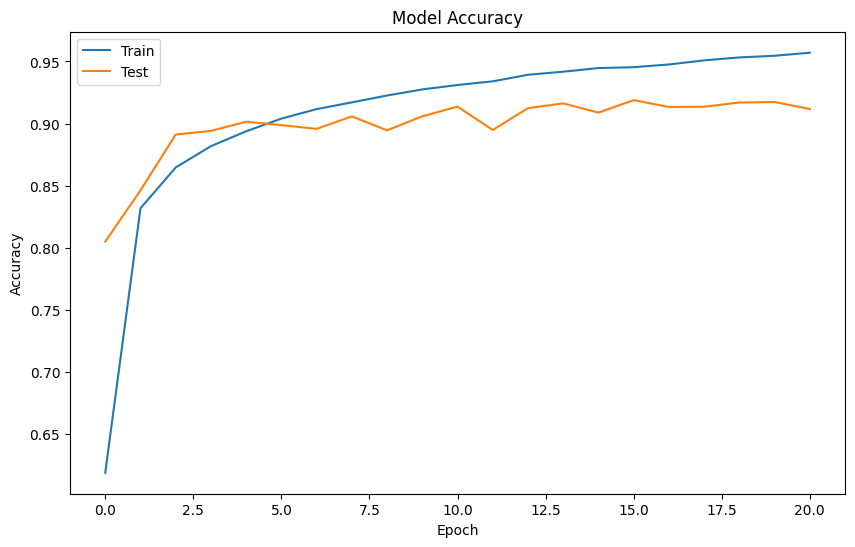

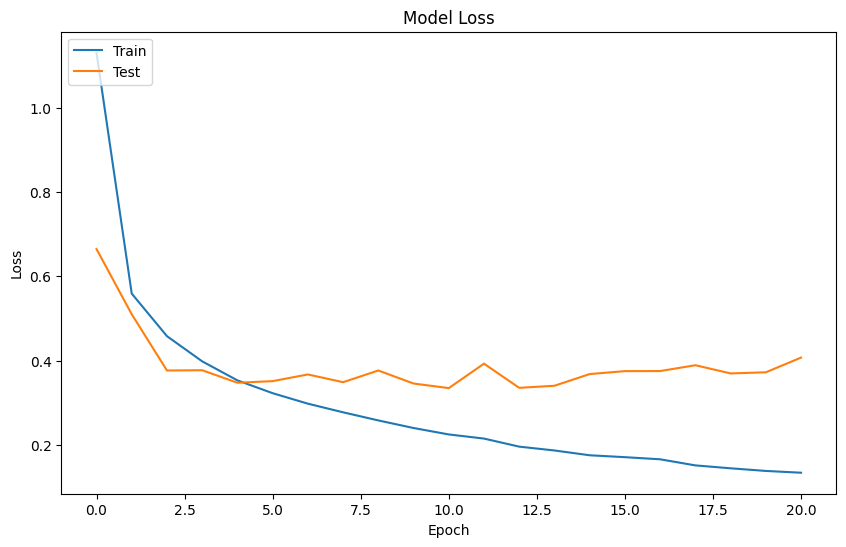

In [183]:
plot_accuracy(history)
plot_loss(history)

In [184]:
def display_predictions(model, x_test, y_test, num_images=5):
    num_test_images = x_test.shape[0]
    idxs = np.random.choice(num_test_images, num_images)

    random_test_images = x_test[idxs]
    random_test_labels = y_test[idxs]

    predictions_cnn = model.predict(random_test_images)

    fig, axes = plt.subplots(num_images, 2, figsize=(12, 3 * num_images), dpi=100)

    for i in range(num_images):
        img = random_test_images[i]
        label = random_test_labels[i]
        preds_cnn = predictions_cnn[i]

        ax_img_gray = axes[i, 0]
        ax_img_gray.imshow(img.squeeze(), cmap='gray')
        ax_img_gray.axis('off')
        ax_img_gray.set_title(f'Grayscale Digit {label}')

        ax_bar = axes[i, 1]
        ax_bar.bar(range(len(preds_cnn)), preds_cnn, color='blue')
        ax_bar.set_xticks(range(len(preds_cnn)))
        ax_bar.set_title(f'Prediction: {np.argmax(preds_cnn)}')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


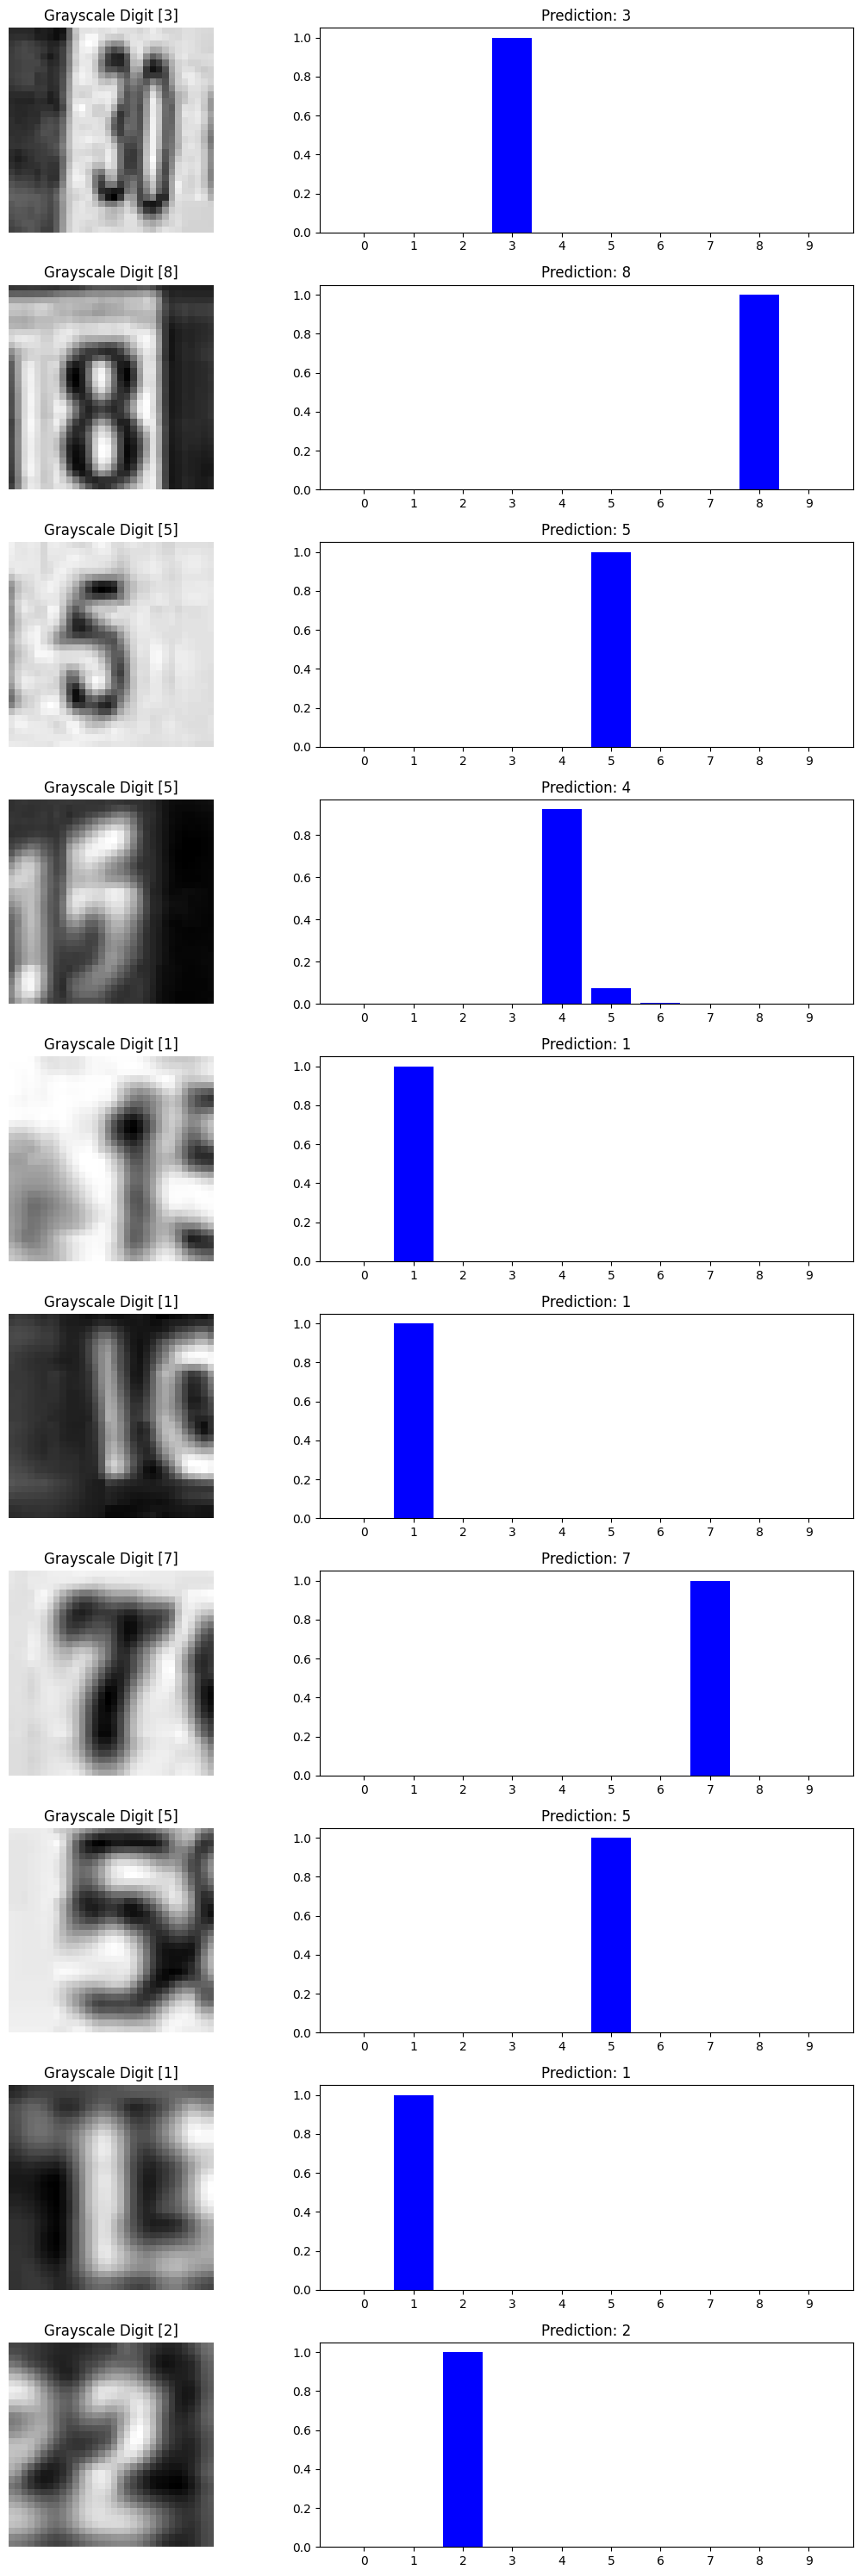

In [191]:
display_predictions(model_cnn, x_test, y_test, num_images=10)

# Save and Load Model

In [186]:
model_cnn.save('final_model.keras')


model = load_model('final_model.keras')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])